In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import sem

In [4]:
def get_max_time(filename, show_graph=False):
    df = pd.read_csv(filename)
    df.columns = ["Time", "Value"]

    open_index = df[df["Time"] == "Valve opened"].index[0]
    df = df[open_index + 1:]
    df["Time"] = df["Time"].astype(float)
    df["Time"] /= 1000
    df["Value"] = df["Value"].astype(float)

    # get derivative of value wrt time
    df["Value_avg"] = df["Value"].rolling(40).mean()
    df["Derivative"] = df["Value_avg"].diff(40) / df["Time"].diff(40)

    max_time = df[df["Derivative"] == df["Derivative"].max()]["Time"].values[0]
    
    if show_graph:
        plt.clf()
        ax1, ax2 = plt.subplots(2, 1, sharex=True)
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        ax1.plot(df["Time"], df["Value_avg"])
        ax2.plot(df["Time"], df["Derivative"])
        plt.show()

    return max_time - df["Time"].values[0]

<Figure size 432x288 with 0 Axes>

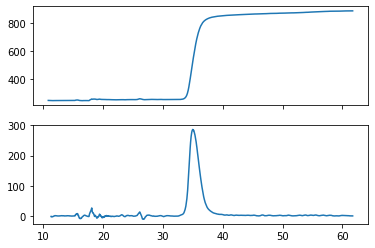

24.587999999999997

In [8]:
get_max_time("../iodine_clock_0.99M_SA/0.2mmolKI.csv", show_graph=True)

m -0.5604241796240476 b 8.642692890454649
Linear RMSE 1.2663442443799782


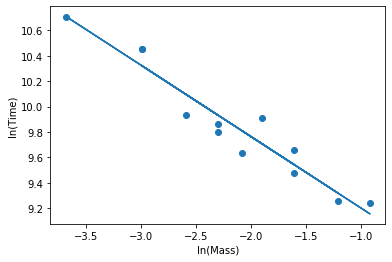

R2 0.9240759189155902
RMSE 0.09413488429376485


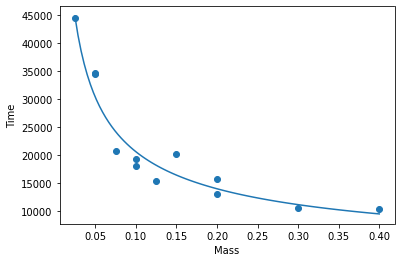

In [11]:
directory = "."
excluded = []

data = pd.DataFrame(columns=["Mass", "Time"])
for filename in os.listdir(directory):
    if filename in excluded:
        continue
    filepath = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue

    mass = float(filename.split("mmolKI")[0])
    time = get_max_time(filepath)
    data.loc[len(data)] = [mass, time]

#data = data[data["Mass"] > 0.05]

data["ln(Mass)"] = np.log(data["Mass"])
data["ln(Time)"] = np.log(data["Time"])

x_col = "ln(Mass)"
y_col = "ln(Time)"
plt.scatter(data[x_col], data[y_col])

m, b = np.polyfit(data[x_col], data[y_col], 1)
print("m", m, "b", b)
linear_rmse = np.sqrt(np.mean((m * data[x_col] + b - data[y_col]) ** 2))
print("Linear RMSE", linear_rmse / (data[y_col].max() - data[y_col].min()) * 15)

plt.plot(data[x_col], m * data[x_col] + b)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.show()

print("R2", np.corrcoef(data[x_col], data[y_col])[0, 1] ** 2)
data["Time_pred"] = np.exp(m * np.log(data["Mass"]) + b)
rmse = np.sqrt(np.mean(data["Time_pred"] - data["Time"]) ** 2)

y_min = data["Time"].min()
y_max = data["Time"].max()
print("RMSE", rmse / (y_max - y_min) * 15)

plt.scatter(data["Mass"], data["Time"])

mass_range = np.linspace(data["Mass"].min(), data["Mass"].max(), 100)
time_range = np.exp(m * np.log(mass_range) + b)
plt.plot(mass_range, time_range)

plt.xlabel("Mass")
plt.ylabel("Time")
plt.show()